In [41]:
import pandas as pd
import gurobipy as grb
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

# Retrieving and processing simulation data
The data set that was obtained form the simulation is now added into this notebook. After that a bit of processing is done to get the data set in the right format

In [30]:
# ADD DATAFRAME WITH DATA FROM SIMULATION
df = pd.read_csv('data/LP data/df_lp.csv')
df.drop('Time', axis = 1, inplace = True)
df.insert(len(df.columns)-1, 'Simulation', df.pop('Simulation'))

# Model formulations
The goal of this linear optimization model is to determine the optimal values for $k_i$, the max buffer sizes for each buffer. The data given is the processing speeds (v) per minute (t) per machine, the maximum capacity of all buffers combined and the total amount of time running.

## Sets and indices
 - *t* $\in$ Time = {1,2,...,10} : production time
 - *j* $\in$ Buffers = {0, 1, 2, 3, 4, 5} : set of buffers
 - *i* $\in$ Machines = {1, 2, 3, 4, 5} : set of machines
 
## Parameters
 - *th*$_i(t)$ $\in$ $\mathbb{R}_0^+$ : The throughput of every machine *i* at time (t), $\forall$ *i* $\in$ {1, 2, 3, 4, 5}
 - *v*$_i(t)$* $\in$ $\mathbb{N}_0$: The speed of machine *i* at time (t)
 - *b*$_j(t)$ $\in$ $\mathbb{R}_0^+$: The actual amount of products in the buffer at a point in time (t), $\forall$ *i* $\in$ {1, 2, 3, 4}
 - *k*$_{max}$ : The max amount of products in all buffers at the same time.
 
## Decision Variables
 - *k*$_j$ $\in$ $\mathbb{N}_0$: The maximum capacity of each corresponding buffer, $\forall$ *j* $\in$ {1, 2, 3, 4, 5}

**Assumption**: We can produce and store fractional units. These will get rounded at the end.
 
## Objective function
Maximize the total amount of products in the last buffer. This means that the production of the whole line is maximized.

\begin{equation}
\text{max.} \quad \sum_{t \in T} b_5(t)
\end{equation}

## Constraints
**Throughput Machine 5 1**
 - $th_5(t) \leq v_5(t)$ : The throughput of machine 5 cannot exceed the speed of machine 5.

**Throughput Machine 5 2**
 - $th_5(t) \leq b_4(t-1)$ : The throughput of machine 5 cannot exceed the amount of products in buffer $b_4$.

**Ammount buffer 5**
 - $b_5(t) = th_5$ : The amount of products coming into buffer $b_5$ is equal to the throughput of machine 5.

**Buffer max**
 - $b_j(t) \leq k_j$ : The amount of products in buffer $b_j$ cannot exceed the maximum capacity $k_j$.

**Amount buffers 1**
 - $b_j(t) \leq b_j(t-1) - th_{i+1}(t) + v_i(t)$ : The amount of products coming into buffer $b_j$ at *(t)* cannot exceed the amount of units in the buffer $b_j$ at *(t-1)* minus the throughput of the next machine plus the speed of the previous machione at *(t)*.

**Amount buffers 2**
 - $b_j(t) \leq b_j(t-1) - th_{i+1}(t) + b_{j-1}(t-1)$ : The amount of products coming into buffer $b_j$ at *(t)* cannot exceed the amount of units in the buffer $b_j$ at *(t-1)* minus the throughput of the next machine at *(t)* plus the amount of products in the previous buffer at *(t-1)* .

**Throughput machines**
 - $th_i(t) = b_j(t) - b_j(t-1) - th_{i+1}(t)$ : The throughput of machine *i* is equal to the amount of units in the buffer at time *(t)* minus the difference between the previous amount in buffer $b_j$ and the throughput of the following machine at time *(t)*.
 
**Max. Total buffer capacity**
 - $k_1 + k_2 + k_3 + k_4 \leq 40$ - This states that the max capacity of all buffers summed up cannot exceed 40 units. (This only caounts for the small test data sets as of now)
 
And everything has to be positive.

In [53]:
# Create dictionary to save values
opt_values = []

In [54]:
begin = datetime.now()
for sim in range(10):
    speed = df[df['Simulation'] == (sim+1)].reset_index(drop = True)
    speed.drop('Simulation', axis=1, inplace = True)
    speed = speed.transpose()

    # DATA INPUT
    machines = [i+1 for i in range(7)]  # there are 7 machines and machines start with 1
    times = [i for i in range(481)]  # The runtime of the simulated data is 480 minutes
    buffers = [i for i in range(8)]  # There are 8 buffers and buffers start with 0

    # PARAMETERS
    maximum_capacity_all_buffers = 50000
    pspeed = {(i,t): speed.iloc[i-1, t] for i in machines for t in times}
    #INITIALIZATION
    model = grb.Model()

    #VARIABLES
    throughput = {(i, t): model.addVar(lb=0, vtype=grb.GRB.CONTINUOUS, name=f"th_M{i}(T{t})") for i in machines for t in times} 
    buffer = {(j, t): model.addVar(lb=0, vtype=grb.GRB.CONTINUOUS, name=f"buffer_B{j}(T{t})") for j in buffers for t in times} 
    max_cap_buffer = {j: model.addVar(lb=0, vtype=grb.GRB.CONTINUOUS, name=f"max_buffer_B{j}") for j in buffers} 
    obj_func = model.addVar(lb=0, vtype=grb.GRB.CONTINUOUS, name="obj")

    # CONSTRAINTS
    # THROUGHPUT MACHINE 7 1
    for t in times: 
        th7_1 = model.addConstr(throughput[(7,t)], grb.GRB.LESS_EQUAL, pspeed[(7,t)], name=f"Throughput1_Machine7_T{t}") 
    # THROUGHPUT MACHINE 7 2
    for t in times: 
        th5_2 = model.addConstr(throughput[(7,t)], grb.GRB.LESS_EQUAL, buffer[(7,t)], name=f"Throughput2_Machine7_T{t}")
    # AMOUNT BUFFER 7
    for t in times: 
        b5 = model.addConstr(throughput[(7,t)], grb.GRB.EQUAL, buffer[(7,t)], name=f"AmountBuffer_Machine7_T{t}")
    # BUFFER MAX
    for j in buffers[1:-1]: 
        for t in times: 
            bmax = model.addConstr(buffer[(j,t)], grb.GRB.LESS_EQUAL, max_cap_buffer[j], name=f"Max_Single_Buffer_B{j}_T{t}")
    # AMOUNT BUFFERS
    for j in buffers[1:-1]: 
        for t in times[1:]: 
            amount_b_1 = model.addConstr(buffer[(j, t)], grb.GRB.LESS_EQUAL, buffer[(j, t-1)] - throughput[(j+1, t)] + pspeed[(j, t)]) 
            amount_b_2 = model.addConstr(buffer[(j, t)], grb.GRB.LESS_EQUAL, buffer[(j, t-1)] - throughput[(j+1, t)] + buffer[(j-1, t-1)])
    # THROUGHPUT MACHINES
    for i in machines[:-1]:
        for j in buffers:
            for t in times[1:]: 
                th_all = model.addConstr(throughput[(i,t)], grb.GRB.EQUAL, buffer[(j,t)] - buffer[(j, t-1)] + throughput[(i+1, t)] )
    # MAX TOTAL BUFFER
    model.addConstr(grb.quicksum(max_cap_buffer[j] for j in buffers[1:-1]), grb.GRB.LESS_EQUAL, maximum_capacity_all_buffers, name="Max_Total_Buffer")
    # OBJECTIVE FUNCTION CONSTRAINT
    model.addConstr(obj_func, grb.GRB.LESS_EQUAL, grb.quicksum(buffer[(7,t)] for t in times), name="obj_func_constraint")

    # OBJECTIVE FUNCTION
    model.setObjective(obj_func, grb.GRB.MAXIMIZE)

    # OPTIMIZATION
    model.optimize() 
    model.write("BAP_optimization.lp")

    if not model.status == grb.GRB.OPTIMAL:
        print("something went wrong")

    # SOLUTION
    opt_values.append({'Sim': sim+1,
                  'Buffer 1': max_cap_buffer[1].X,
                  'Buffer 2': max_cap_buffer[2].X,
                  'Buffer 3': max_cap_buffer[3].X,
                  'Buffer 4': max_cap_buffer[4].X,
                  'Buffer 5': max_cap_buffer[5].X,
                  'Buffer 6': max_cap_buffer[6].X})
print(datetime.now() - begin)

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 33131 rows, 7224 columns and 120985 nonzeros
Model fingerprint: 0x12e64e5e
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 5e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 32511 rows and 6946 columns
Presolve time: 0.10s
Presolved: 620 rows, 278 columns, 2081 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 7.662e+03
 Factor NZ  : 4.326e+04 (roughly 1 MB of memory)
 Factor Ops : 3.623e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.13577793e+06  2.44727620e+04  8.69e+04 4.86e-02  8.07e+03     0s
   1   9.10478646e+04  8.8

Optimal objective  1.447500000e+02
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 33131 rows, 7224 columns and 120985 nonzeros
Model fingerprint: 0x31cc6e16
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+01, 5e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 32945 rows and 7139 columns
Presolve time: 0.10s
Presolved: 186 rows, 85 columns, 614 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.978e+03
 Factor NZ  : 7.813e+03
 Factor Ops : 4.039e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.13436088e+05  6.13616510e+03  8.46e+04 1.99e-02  5.27e+03     0s
   1   4.94722613e

In [82]:
df_optvalues = pd.DataFrame(opt_values)
df_optvalues.drop('Sim', axis = 1, inplace = True)
df_optvalues = df_optvalues[(df_optvalues.T != 0).any()]
df_optvalues

,Buffer 1,Buffer 2,Buffer 3,Buffer 4,Buffer 5,Buffer 6
0,46866.250000,857.750000,752.750000,647.750000,542.750000,332.750000
2,47015.000000,828.000000,723.000000,618.000000,513.000000,303.000000
3,47813.000000,675.000000,567.000000,459.000000,351.000000,135.000000
4,47245.000000,870.000000,725.000000,580.000000,435.000000,145.000000
5,47249.750000,868.500000,723.750000,579.000000,434.250000,144.750000
6,47482.000000,734.600000,629.600000,524.600000,419.600000,209.600000
7,47118.333333,822.916667,710.833333,598.750000,486.666667,262.500000
8,1025.828571,905.828571,785.828571,665.828571,545.828571,46070.857143
9,50000.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [83]:
df_optvalues.mean()

Buffer 1    42423.906878
Buffer 2      729.177249
Buffer 3      624.195767
Buffer 4      519.214286
Buffer 5      414.232804
Buffer 6     5289.273016
dtype: float64

C:\Users\GijsTempelman\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<function matplotlib.pyplot.show(close=None, block=None)>

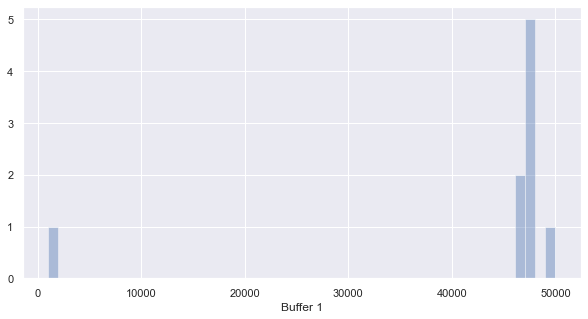

In [84]:
sns.set(rc = {'figure.figsize':(10,5)})
sns.distplot(df_optvalues['Buffer 1'], kde = False)
plt.show